In [1]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
from AFLPy.AFLData_Client import load_data, upload_data, metadata

Data

In [3]:
md = metadata(ID = "AFL")
afltables_player_stats = load_data(Dataset_Name='AFLTables_Player_Stats', ID = "AFL")
afl_team_positions = load_data(Dataset_Name='AFL_API_Team_Positions', ID = "AFL")
player_positions = afl_team_positions[['Player_ID', 'Match_ID', 'Position', 'Position_Sub_Group', 'Position_Group']]
chains = load_data(Dataset_Name='AFL_API_Match_Chains', ID = 'AFL')
shots = pd.read_csv(r"/Users/ciaran/Documents/Projects/AFL/git-repositories/expected-score-model/data/predictions/shots_xs_catboost.csv")
shots['Year'] = shots['Match_ID'].apply(lambda x: int(x.split("_")[1]))
shots['Round'] = shots['Match_ID'].apply(lambda x: x.split("_")[2])

In [4]:
shots.head()

,CD_Player_ID,Chain_Number,Team_Chain,Initial_State,Final_State,Period_Number,Period_Duration_Chain_Start,Description,Disposal,Shot_At_Goal,Behind_Detail,Order,Period_Duration,x,y,Home_Team,Away_Team,Home_Team_Direction_Q1,Venue_Width,Venue_Length,Player,Team,Match_ID,Player_ID,result,score,miss,behind,goal,predicted_result,behind_probas,goal_probas,miss_probas,xscore,angle,angle_degrees,chain_duration,description_0,description_1,description_2,description_3,distance,distance_log,distance_since_last_action,distance_squared,distance_to_goal_x,distance_to_middle_y,ground_kick,initial_state,period_duration_0,period_duration_1,period_duration_2,period_duration_3,set_shot,time_since_last_action,visible_behind_angle,visible_behind_angle_degrees,visible_goal_angle,visible_goal_angle_degrees,x_0,x_1,x_2,x_3,y_0,y_1,y_2,y_3,Year,Round
0,CD_I990609,5,Brisbane,possGain,behind,1.0,50.0,Kick,ineffective,True,NaN,48.0,118.0,44.0,12.0,Sydney,Brisbane,right,141.0,160.0,Charlie Cameron,Brisbane,AFL_2024_F4_Sydney_Brisbane,charlie_cameron,behind,1,0,1,0,goal,0.326611,0.639306,0.034083,4.162447,0.321751,18.434949,68.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,37.947332,3.636199,8.246211,1440.0,36.0,12.0,0,possGain,118.0,76.0,74.0,72.0,1,42.0,0.512821,29.382451,0.161146,9.232981,44.0,52.0,51.0,34.0,12.0,10.0,10.0,55.0,2024,F4
1,CD_I294518,12,Brisbane,possGain,behind,1.0,270.0,Kick,ineffective,True,NaN,112.0,327.0,56.0,-33.0,Sydney,Brisbane,right,141.0,160.0,Joe Daniher,Brisbane,AFL_2024_F4_Sydney_Brisbane,joe_daniher,behind,1,0,1,0,goal,0.412004,0.453756,0.134240,3.134539,0.942000,53.972627,57.0,Kick,Mark On Lead,Kick Inside 50 Result,Kick Into F50,40.804412,3.708790,8.944272,1665.0,24.0,33.0,0,possGain,327.0,292.0,291.0,290.0,1,35.0,0.292973,16.786129,0.092823,5.318374,56.0,60.0,60.0,22.0,-33.0,-25.0,-25.0,-64.0,2024,F4
2,CD_I1006126,22,Sydney,throwIn,behind,1.0,550.0,Kick,ineffective,True,NaN,196.0,558.0,64.0,15.0,Sydney,Brisbane,right,141.0,160.0,James Rowbottom,Sydney,AFL_2024_F4_Sydney_Brisbane,james_rowbottom,behind,1,0,1,0,goal,0.389350,0.460539,0.150111,3.152583,0.753151,43.152390,8.0,Kick,Loose Ball Get,Gather,Contested Knock On,21.931712,3.087934,4.472136,481.0,16.0,15.0,0,throwIn,558.0,557.0,552.0,550.0,0,1.0,0.790042,45.266082,0.217521,12.463013,64.0,60.0,59.0,61.0,15.0,17.0,15.0,16.0,2024,F4
3,CD_I997100,24,Sydney,possGain,goal,1.0,576.0,Kick,effective,True,NaN,207.0,596.0,58.0,-21.0,Sydney,Brisbane,right,141.0,160.0,Will Hayward,Sydney,AFL_2024_F4_Sydney_Brisbane,will_hayward,goal,6,0,0,1,goal,0.350931,0.598992,0.050077,3.944881,0.762147,43.667780,20.0,Kick,Free Advantage,Free For,Kick Inside 50 Result,30.413813,3.414897,7.615773,925.0,22.0,21.0,0,possGain,596.0,595.0,594.0,589.0,1,1.0,0.507180,29.059288,0.153920,8.818975,58.0,55.0,62.0,62.0,-21.0,-28.0,-30.0,-30.0,2024,F4
4,CD_I996765,25,Sydney,centreBounce,goal,1.0,659.0,Kick,effective,True,NaN,218.0,677.0,51.0,28.0,Sydney,Brisbane,right,141.0,160.0,Tom Papley,Sydney,AFL_2024_F4_Sydney_Brisbane,tom_papley,goal,6,0,0,1,behind,0.467258,0.302938,0.229804,2.284884,0.767856,43.994914,18.0,Kick,Handball Received,Handball,Gather,40.311289,3.696632,10.000000,1625.0,29.0,28.0,0,centreBounce,677.0,675.0,673.0,673.0,0,2.0,0.363247,20.812538,0.114940,6.585559,51.0,45.0,48.0,50.0,28.0,20.0,19.0,19.0,2024,F4


Create Difference between Actual and Expected

In [9]:
shots['xscore_difference'] = shots['score'] - shots['xscore']

Aggregate shots to player and match level

In [10]:
def create_player_match_summary(shots, positions, percent_played):
    
    player_match_summary = shots.groupby(['Player_ID', 'Player', 'Team', 'Match_ID', 'Year']).agg(
        score = ('score', 'sum'),
        xscore = ('xscore', 'sum'),
        xdiff = ('xscore_difference', 'sum'),
        num_shots = ('score', 'size'),
        num_games = ('Match_ID', 'nunique')
    )
    player_match_summary = player_match_summary.reset_index().merge(positions, how = 'left', left_on=['Player_ID', 'Match_ID'], right_on=['Player_ID', 'Match_ID'])
    player_match_summary = player_match_summary.merge(percent_played[['Match_ID', 'Player_ID', 'Percent_Played']], how = 'left', left_on=['Player_ID', 'Match_ID'], right_on=['Player_ID', 'Match_ID'] )
    player_match_summary = player_match_summary.drop(columns=['Player_ID'])
    
    return player_match_summary
    

In [11]:
player_match_summary = create_player_match_summary(shots, player_positions, percent_played=afltables_player_stats[['Match_ID', 'Player_ID', 'Percent_Played']])
player_match_summary.head()

,Player,Team,Match_ID,Year,score,xscore,xdiff,num_shots,num_games,Position,Position_Sub_Group,Position_Group,Percent_Played
0,Aaron Black,West Coast,AFL_2022_02_NorthMelbourne_WestCoast,2022,6,3.247522,2.752478,2,1,Ruck Rover,Centre,Midfield,75.0
1,Aaron Cadman,Greater Western Sydney,AFL_2023_05_GreaterWesternSydney_Hawthorn,2023,6,4.367239,1.632761,1,1,Interchange,Interchange,Interchange,62.0
2,Aaron Cadman,Greater Western Sydney,AFL_2023_06_GreaterWesternSydney_Brisbane,2023,6,4.403906,1.596094,1,1,Interchange,Interchange,Interchange,63.0
3,Aaron Cadman,Greater Western Sydney,AFL_2023_07_Sydney_GreaterWesternSydney,2023,6,7.490939,-1.490939,3,1,Interchange,Interchange,Interchange,43.0
4,Aaron Cadman,Greater Western Sydney,AFL_2023_08_GreaterWesternSydney_WesternBulldogs,2023,6,1.841222,4.158778,1,1,Interchange,Interchange,Interchange,50.0


In [35]:
def create_expected_score_summary(player_match_summary, group_cols, min_shots=50, min_games = 20, sort_by = 'xscore'):
    
    shots_groupby = player_match_summary.groupby(group_cols).agg(
        score = ('score', 'sum'),
        xscore = ('xscore', 'sum'),
        xdiff = ('xdiff', 'sum'),
        num_shots = ('num_shots', 'sum'),
        num_games = ('num_games', 'sum'),
        percent_played = ('Percent_Played', 'mean')
    )
    shots_groupby['score_per_shot'] = shots_groupby['score'] / shots_groupby['num_shots']
    shots_groupby['score_per_game'] = shots_groupby['score'] / shots_groupby['num_games']

    shots_groupby['xscore_per_shot'] = shots_groupby['xscore'] / shots_groupby['num_shots']
    shots_groupby['xscore_per_game'] = shots_groupby['xscore'] / shots_groupby['num_games']
    
    shots_groupby['shots_per_game'] = shots_groupby['num_shots'] / shots_groupby['num_games']
    
    shots_groupby['xdiff_per_shot'] = shots_groupby['xdiff'] / shots_groupby['num_shots']
    shots_groupby['xdiff_per_game'] = shots_groupby['xdiff'] / shots_groupby['num_games']
    
    shots_groupby['score_per_90pc'] = 90 * shots_groupby['score'] / shots_groupby['percent_played'] / shots_groupby['num_games']
    shots_groupby['xscore_per_90pc'] = 90 * shots_groupby['xscore'] / shots_groupby['percent_played'] / shots_groupby['num_games']
    shots_groupby['shots_per_90pc'] = 90 * shots_groupby['num_shots'] / shots_groupby['percent_played'] / shots_groupby['num_games']
    shots_groupby['xdiff_per_90pc'] = 90 * shots_groupby['xdiff'] / shots_groupby['percent_played'] / shots_groupby['num_games']
    
    return shots_groupby[(shots_groupby['num_shots'] > min_shots) & (shots_groupby['num_games'] > min_games)].sort_values(sort_by, ascending=False)

Expected Score Difference Per Shot

In [38]:
player_summary = create_expected_score_summary(player_match_summary, group_cols='Player', sort_by='xdiff_per_shot')

In [39]:
player_summary.head()

,score,xscore,xdiff,num_shots,num_games,percent_played,score_per_shot,score_per_game,xscore_per_shot,xscore_per_game,shots_per_game,xdiff_per_shot,xdiff_per_game,score_per_90pc,xscore_per_90pc,shots_per_90pc,xdiff_per_90pc
Player,,,,,,,,,,,,,,,,,
Kade Chandler,275,219.087077,55.912923,70,38,74.710526,3.928571,7.236842,3.129815,5.765449,1.842105,0.798756,1.471393,8.717858,6.945346,2.219091,1.772513
Josh J. Kennedy,514,424.097375,89.902625,134,33,84.606061,3.835821,15.575758,3.164906,12.851436,4.060606,0.670915,2.724322,16.568768,13.670761,4.319484,2.898007
Jason Johannisen,188,156.839442,31.160558,51,32,76.656250,3.686275,5.875000,3.075283,4.901233,1.593750,0.610991,0.973767,6.897676,5.754403,1.871178,1.143274
Taylor Walker,1336,1119.699432,216.300568,363,75,84.440000,3.680441,17.813333,3.084571,14.929326,4.840000,0.595869,2.884008,18.986262,15.912356,5.158693,3.073907
Peter Wright,777,663.282124,113.717876,192,55,89.909091,4.046875,14.127273,3.454594,12.059675,3.490909,0.592281,2.067598,14.141557,12.071869,3.494439,2.069688


In [40]:
player_summary.tail()

,score,xscore,xdiff,num_shots,num_games,percent_played,score_per_shot,score_per_game,xscore_per_shot,xscore_per_game,shots_per_game,xdiff_per_shot,xdiff_per_game,score_per_90pc,xscore_per_90pc,shots_per_90pc,xdiff_per_90pc
Player,,,,,,,,,,,,,,,,,
Lachlan McNeil,178,220.389285,-42.389285,63,36,73.000000,2.825397,4.944444,3.498243,6.121925,1.750000,-0.672846,-1.177480,6.095890,7.547578,2.157534,-1.451688
Liam Henry,137,180.419788,-43.419788,59,34,77.558824,2.322034,4.029412,3.057963,5.306464,1.735294,-0.735929,-1.277053,4.675768,6.157672,2.013652,-1.481904
Jye Menzie,178,225.087391,-47.087391,62,29,69.000000,2.870968,6.137931,3.630442,7.761634,2.137931,-0.759474,-1.623703,8.005997,10.123871,2.788606,-2.117874
Laitham Vandermeer,150,192.965569,-42.965569,56,33,72.454545,2.678571,4.545455,3.445814,5.847441,1.696970,-0.767242,-1.301987,5.646173,7.263447,2.107905,-1.617274
Nat Fyfe,159,230.050988,-71.050988,71,37,72.108108,2.239437,4.297297,3.240155,6.217594,1.918919,-1.000718,-1.920297,5.363568,7.760341,2.395052,-2.396772


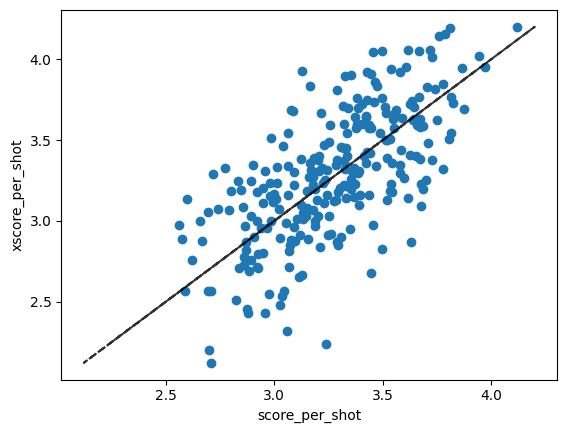

In [44]:
import matplotlib.pyplot as plt

plt.scatter(player_summary['xscore_per_shot'], player_summary['score_per_shot'])
plt.plot(player_summary['score_per_shot'], player_summary['score_per_shot'], ls = 'dashed', c = 'black', alpha = 0.8)
plt.ylabel('xscore_per_shot')
plt.xlabel('score_per_shot')

plt.show()

Expected Score Difference Total

In [45]:
player_summary = create_expected_score_summary(player_match_summary, group_cols='Player', sort_by='xdiff')

In [53]:
player_summary.head(10)

score      xscore      xdiff  num_shots  num_games  \
Player         Year                                                       
Taylor Walker  2023    496  401.560650  94.439350        129         22   
Charlie Curnow 2023    524  449.838484  74.161516        133         26   
Nick Larkey    2023    450  388.092052  61.907948        100         23   
Bayley Fritsch 2021    385  330.138535  54.861465         93         24   
               2022    352  300.961980  51.038020         88         24   
Jeremy Cameron 2024    437  386.260226  50.739774        124         24   
Lance Franklin 2022    352  303.677244  48.322756         93         22   
Zac Bailey     2022    246  200.675942  45.324058         63         21   
Chad Warner    2024    235  191.185655  43.814345         61         22   
Bayley Fritsch 2024    275  231.381918  43.618082         74         21   

                     percent_played  score_per_shot  score_per_game  \
Player         Year                                                   
Taylor Walker  2023       82.863636        3.844961       22.545455   
Charlie Curnow 2023       93.730769        3.939850       20.153846   
Nick Larkey    2023       96.347826        4.500000       19.565217   
Bayley Fritsch 2021       85.375000        4.139785       16.041667   
               2022       83.791667        4.000000       14.666667   
Jeremy Cameron 2024       95.500000        3.524194       18.208333   
Lance Franklin 2022       89.181818        3.784946       16.000000   
Zac Bailey     2022       81.428571        3.904762       11.714286   
Chad Warner    2024       81.761905        3.852459       10.681818   
Bayley Fritsch 2024       85.952381        3.716216       13.095238   

                     xscore_per_shot  xscore_per_game  shots_per_game  \
Player         Year                                                     
Taylor Walker  2023         3.112873        18.252757        5.863636   
Charlie Curnow 2023         3.382244        17.301480        5.115385   
Nick Larkey    2023         3.880921        16.873567        4.347826   
Bayley Fritsch 2021         3.549877        13.755772        3.875000   
               2022         3.420023        12.540083        3.666667   
Jeremy Cameron 2024         3.115002        16.094176        5.166667   
Lance Franklin 2022         3.265347        13.803511        4.227273   
Zac Bailey     2022         3.185332         9.555997        3.000000   
Chad Warner    2024         3.134191         8.690257        2.772727   
Bayley Fritsch 2024         3.126783        11.018187        3.523810   

                     xdiff_per_shot  xdiff_per_game  score_per_90pc  \
Player         Year                                                   
Taylor Walker  2023        0.732088        4.292698       24.487109   
Charlie Curnow 2023        0.557605        2.852366       19.351662   
Nick Larkey    2023        0.619079        2.691650       18.276173   
Bayley Fritsch 2021        0.589908        2.285894       16.910688   
               2022        0.579977        2.126584       15.753357   
Jeremy Cameron 2024        0.409192        2.114157       17.159686   
Lance Franklin 2022        0.519600        2.196489       16.146789   
Zac Bailey     2022        0.719429        2.158288       12.947368   
Chad Warner    2024        0.718268        1.991561       11.758088   
Bayley Fritsch 2024        0.589434        2.077052       13.711911   

                     xscore_per_90pc  shots_per_90pc  xdiff_per_90pc  
Player         Year                                                   
Taylor Walker  2023        19.824717        6.368623        4.662392  
Charlie Curnow 2023        16.612829        4.911777        2.738833  
Nick Larkey    2023        15.761861        4.061372        2.514312  
Bayley Fritsch 2021        14.500961        4.084919        2.409728  
               2022        13.469208        3.938339        2.284148  
Jeremy Cameron 2024        15.167286    

In [54]:
player_summary.tail(10)

,,score,xscore,xdiff,num_shots,num_games,percent_played,score_per_shot,score_per_game,xscore_per_shot,xscore_per_game,shots_per_game,xdiff_per_shot,xdiff_per_game,score_per_90pc,xscore_per_90pc,shots_per_90pc,xdiff_per_90pc
Player,Year,,,,,,,,,,,,,,,,,
Joe Daniher,2024,399,434.936507,-35.936507,130,27,97.192308,3.069231,14.777778,3.345665,16.108760,4.814815,-0.276435,-1.330982,13.684211,14.916699,4.458515,-1.232488
Jack Higgins,2023,254,291.465307,-37.465307,83,21,79.142857,3.060241,12.095238,3.511630,13.879300,3.952381,-0.451389,-1.784062,13.754513,15.783320,4.494585,-2.028807
Ben Ainsworth,2022,170,207.637831,-37.637831,61,21,84.000000,2.786885,8.095238,3.403899,9.887516,2.904762,-0.617014,-1.792278,8.673469,10.593767,3.112245,-1.920298
Jack Ginnivan,2024,193,230.888225,-37.888225,72,23,81.043478,2.680556,8.391304,3.206781,10.038618,3.130435,-0.526225,-1.647314,9.318670,11.148037,3.476395,-1.829367
Bobby Hill,2024,215,253.040087,-38.040087,72,22,79.045455,2.986111,9.772727,3.514446,11.501822,3.272727,-0.528335,-1.729095,11.127085,13.095807,3.726279,-1.968722
Brody Mihocek,2022,272,310.117686,-38.117686,84,23,90.478261,3.238095,11.826087,3.691877,13.483378,3.652174,-0.453782,-1.657291,11.763575,13.412106,3.632869,-1.648530
Christian Petracca,2022,146,186.374902,-40.374902,69,23,87.826087,2.115942,6.347826,2.701086,8.103257,3.000000,-0.585144,-1.755431,6.504950,8.303832,3.074257,-1.798882
Jamarra Ugle-Hagan,2023,252,299.388405,-47.388405,93,23,83.478261,2.709677,10.956522,3.219230,13.016887,4.043478,-0.509553,-2.060365,11.812500,14.033831,4.359375,-2.221331
Christian Petracca,2023,202,249.937240,-47.937240,87,25,83.960000,2.321839,8.080000,2.872842,9.997490,3.480000,-0.551003,-1.917490,8.661267,10.716699,3.730348,-2.055432


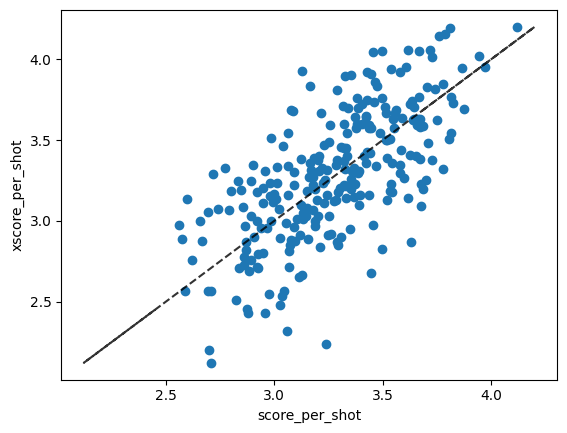

In [48]:
import matplotlib.pyplot as plt

plt.scatter(player_summary['xscore_per_shot'], player_summary['score_per_shot'])
plt.plot(player_summary['score_per_shot'], player_summary['score_per_shot'], ls = 'dashed', c = 'black', alpha = 0.8)
plt.ylabel('xscore_per_shot')
plt.xlabel('score_per_shot')

plt.show()

Expected Score Difference Total per Season

In [49]:
player_summary = create_expected_score_summary(player_match_summary, group_cols=['Player', 'Year'], sort_by='xdiff')

In [50]:
player_summary.head()

score      xscore      xdiff  num_shots  num_games  \
Player         Year                                                       
Taylor Walker  2023    496  401.560650  94.439350        129         22   
Charlie Curnow 2023    524  449.838484  74.161516        133         26   
Nick Larkey    2023    450  388.092052  61.907948        100         23   
Bayley Fritsch 2021    385  330.138535  54.861465         93         24   
               2022    352  300.961980  51.038020         88         24   

                     percent_played  score_per_shot  score_per_game  \
Player         Year                                                   
Taylor Walker  2023       82.863636        3.844961       22.545455   
Charlie Curnow 2023       93.730769        3.939850       20.153846   
Nick Larkey    2023       96.347826        4.500000       19.565217   
Bayley Fritsch 2021       85.375000        4.139785       16.041667   
               2022       83.791667        4.000000       14.666667   

                     xscore_per_shot  xscore_per_game  shots_per_game  \
Player         Year                                                     
Taylor Walker  2023         3.112873        18.252757        5.863636   
Charlie Curnow 2023         3.382244        17.301480        5.115385   
Nick Larkey    2023         3.880921        16.873567        4.347826   
Bayley Fritsch 2021         3.549877        13.755772        3.875000   
               2022         3.420023        12.540083        3.666667   

                     xdiff_per_shot  xdiff_per_game  score_per_90pc  \
Player         Year                                                   
Taylor Walker  2023        0.732088        4.292698       24.487109   
Charlie Curnow 2023        0.557605        2.852366       19.351662   
Nick Larkey    2023        0.619079        2.691650       18.276173   
Bayley Fritsch 2021        0.589908        2.285894       16.910688   
               2022        0.579977        2.126584       15.753357   

                     xscore_per_90pc  shots_per_90pc  xdiff_per_90pc  
Player         Year                                                   
Taylor Walker  2023        19.824717        6.368623        4.662392  
Charlie Curnow 2023        16.612829        4.911777        2.738833  
Nick Larkey    2023        15.761861        4.061372        2.514312  
Bayley Fritsch 2021        14.500961        4.084919        2.409728  
               2022        13.469208        3.938339        2.284148

In [51]:
player_summary.tail()

,,score,xscore,xdiff,num_shots,num_games,percent_played,score_per_shot,score_per_game,xscore_per_shot,xscore_per_game,shots_per_game,xdiff_per_shot,xdiff_per_game,score_per_90pc,xscore_per_90pc,shots_per_90pc,xdiff_per_90pc
Player,Year,,,,,,,,,,,,,,,,,
Brody Mihocek,2022,272,310.117686,-38.117686,84,23,90.478261,3.238095,11.826087,3.691877,13.483378,3.652174,-0.453782,-1.657291,11.763575,13.412106,3.632869,-1.648530
Christian Petracca,2022,146,186.374902,-40.374902,69,23,87.826087,2.115942,6.347826,2.701086,8.103257,3.000000,-0.585144,-1.755431,6.504950,8.303832,3.074257,-1.798882
Jamarra Ugle-Hagan,2023,252,299.388405,-47.388405,93,23,83.478261,2.709677,10.956522,3.219230,13.016887,4.043478,-0.509553,-2.060365,11.812500,14.033831,4.359375,-2.221331
Christian Petracca,2023,202,249.937240,-47.937240,87,25,83.960000,2.321839,8.080000,2.872842,9.997490,3.480000,-0.551003,-1.917490,8.661267,10.716699,3.730348,-2.055432
Aaron Naughton,2021,328,384.478724,-56.478724,98,25,81.640000,3.346939,13.120000,3.923252,15.379149,3.920000,-0.576314,-2.259149,14.463498,16.953986,4.321411,-2.490488


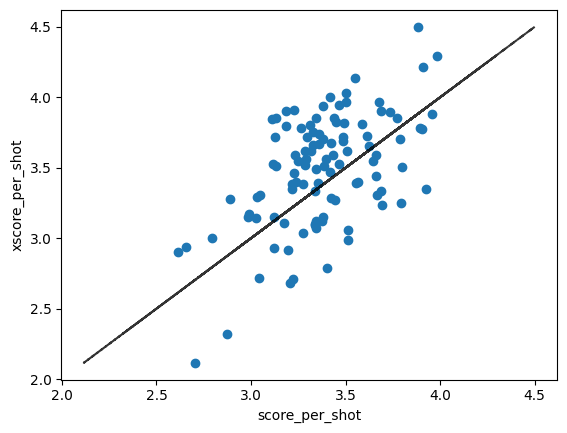

In [52]:
import matplotlib.pyplot as plt

plt.scatter(player_summary['xscore_per_shot'], player_summary['score_per_shot'])
plt.plot(player_summary['score_per_shot'], player_summary['score_per_shot'], ls = 'dashed', c = 'black', alpha = 0.8)
plt.ylabel('xscore_per_shot')
plt.xlabel('score_per_shot')

plt.show()

Expected Score Progression per Shot for a player

In [62]:
import numpy as np

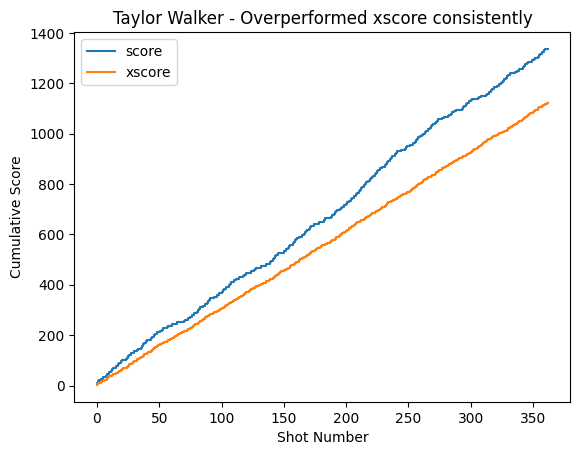

In [78]:
player = 'Taylor Walker'
player_shots = shots[shots['Player'] == player].sort_values(by = "Match_ID")
player_shots['cum_score'] = player_shots['score'].cumsum()
player_shots['cum_xscore'] = player_shots['xscore'].cumsum()

x = np.arange(len(player_shots))
fig,ax = plt.subplots()
ax.step(x, player_shots['cum_score'], label = 'score')
ax.step(x, player_shots['cum_xscore'], label = 'xscore')
ax.set_title(f"{player} - Overperformed xscore consistently")
ax.set_xlabel('Shot Number')
ax.set_ylabel('Cumulative Score')
ax.legend()
fig.show()

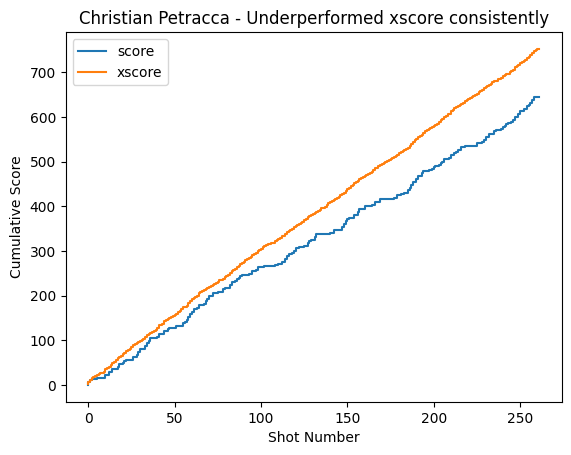

In [80]:
player = 'Christian Petracca'
player_shots = shots[shots['Player'] == player].sort_values(by = "Match_ID")
player_shots['cum_score'] = player_shots['score'].cumsum()
player_shots['cum_xscore'] = player_shots['xscore'].cumsum()

x = np.arange(len(player_shots))
fig,ax = plt.subplots()
ax.step(x, player_shots['cum_score'], label = 'score')
ax.step(x, player_shots['cum_xscore'], label = 'xscore')
ax.set_title(f"{player} - Underperformed xscore consistently")
ax.set_xlabel('Shot Number')
ax.set_ylabel('Cumulative Score')
ax.legend()
fig.show()